In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import zipfile
import os

zip_path = "/content/drive/MyDrive/brain_tumour.zip"
extract_path = "/content/brain_tumour_data" # Or any other desired path

# Create the extraction directory if it doesn't exist
os.makedirs(extract_path, exist_ok=True)

# Extract the zip file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print(f"Successfully extracted {zip_path} to {extract_path}")

Successfully extracted /content/drive/MyDrive/brain_tumour.zip to /content/brain_tumour_data


In [ ]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import jaccard_score, mean_absolute_error, mean_squared_error, fbeta_score
from torch.utils.tensorboard import SummaryWriter

# --------------------------
# Dataset with Proper Resizing
# --------------------------
transform_img = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.ToTensor()
])

transform_mask = transforms.Compose([
    transforms.Resize((256,256), interpolation=Image.NEAREST),  # preserve labels
    transforms.ToTensor()
])

class SegDataset(Dataset):
    def __init__(self, img_dir, mask_dir):
        self.img_dir = img_dir
        self.mask_dir = mask_dir
        self.images = os.listdir(img_dir)
    def __len__(self):
        return len(self.images)
    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.images[idx])
        mask_path = os.path.join(self.mask_dir, self.images[idx])
        img = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")
        img = transform_img(img)
        mask = transform_mask(mask)
        return img, mask

# Dataset paths
img_dir = "/content/brain_tumour_data/images"
mask_dir = "/content/brain_tumour_data/masks"
dataset = SegDataset(img_dir, mask_dir)

# Train/Val split
train_size = int(0.85 * len(dataset))
val_size = len(dataset) - train_size
train_data, val_data = random_split(dataset, [train_size, val_size], generator=torch.Generator().manual_seed(42))

train_loader = DataLoader(train_data,batch_size=4,shuffle=True)
val_loader   = DataLoader(val_data,batch_size=4,shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --------------------------
# Model Components
# --------------------------
class EdgeEnhancement(nn.Module):
    def forward(self,x):
        laplacian_kernel = torch.tensor([[0,-1,0],[-1,4,-1],[0,-1,0]],dtype=torch.float32,device=x.device).unsqueeze(0).unsqueeze(0)
        lap = F.conv2d(x, laplacian_kernel.repeat(x.size(1),1,1,1),padding=1,groups=x.size(1))
        return x + lap

class AdjacentAttention(nn.Module):
    def __init__(self,ch):
        super().__init__()
        self.conv = nn.Conv2d(ch,ch,1)
        self.sigmoid = nn.Sigmoid()
    def forward(self,x1,x2):
        # Assuming x1 and x2 have the same spatial dimensions for attention
        att = self.sigmoid(self.conv(x1+x2))
        return x1*att + x2

class MultiScaleBlock(nn.Module):
    def __init__(self,in_ch,out_ch):
        super().__init__()
        self.conv1 = nn.Conv2d(in_ch,out_ch,3,padding=1)
        self.conv2 = nn.Conv2d(in_ch,out_ch,5,padding=2)
        self.conv3 = nn.Conv2d(in_ch,out_ch,3,dilation=2,padding=2)
        self.fuse  = nn.Conv2d(out_ch*3,out_ch,1)
    def forward(self,x):
        f1,f2,f3 = self.conv1(x),self.conv2(x),self.conv3(x)
        return self.fuse(torch.cat([f1,f2,f3],1))

class ASPP(nn.Module):
    def __init__(self,in_ch,out_ch):
        super().__init__()
        self.conv1 = nn.Conv2d(in_ch,out_ch,1)
        self.conv2 = nn.Conv2d(in_ch,out_ch,3,padding=6,dilation=6)
        self.conv3 = nn.Conv2d(in_ch,out_ch,3,padding=12,dilation=12)
        self.conv4 = nn.Conv2d(in_ch,out_ch,3,padding=18,dilation=18)
        self.pool  = nn.AdaptiveAvgPool2d(1)
        self.proj  = nn.Conv2d(out_ch*5,out_ch,1)
    def forward(self,x):
        h,w = x.shape[2],x.shape[3]
        p = F.interpolate(self.pool(x),size=(h,w),mode="bilinear")
        feats = [self.conv1(x),self.conv2(x),self.conv3(x),self.conv4(x),p]
        return self.proj(torch.cat(feats,1))

class ConvBlock(nn.Module):
    def __init__(self,in_ch,out_ch):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_ch,out_ch,3,padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch,out_ch,3,padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )
    def forward(self,x):
        return self.block(x)

# --------------------------
# FusionNetX
# --------------------------
class FusionNetX(nn.Module):
    def __init__(self,num_classes=1):
        super().__init__()
        self.edge = EdgeEnhancement()
        self.enc1 = ConvBlock(3,64)
        self.enc2 = ConvBlock(64,128)
        self.enc3 = ConvBlock(128,256)
        self.enc4 = ConvBlock(256,512)

        # AdjacentAttention will operate on features at the same level before pooling
        self.att1 = AdjacentAttention(64) # e1
        self.att2 = AdjacentAttention(128) # e2
        self.att3 = AdjacentAttention(256) # e3

        self.msb = MultiScaleBlock(512,512)
        self.aspp = ASPP(512,512)

        self.dec3 = ConvBlock(512+256,256)
        self.dec2 = ConvBlock(256+128,128)
        self.dec1 = ConvBlock(128+64,64)

        self.final = nn.Conv2d(64,num_classes,1)

    def forward(self,x):
        x = self.edge(x)
        e1 = self.enc1(x)
        # Apply attention within the encoder path before pooling
        e1_att = self.att1(e1, e1) # Attention on e1

        e2 = self.enc2(F.max_pool2d(e1,2))
        e2_att = self.att2(e2, e2) # Attention on e2

        e3 = self.enc3(F.max_pool2d(e2,2))
        e3_att = self.att3(e3, e3) # Attention on e3

        e4 = self.enc4(F.max_pool2d(e3,2))

        b = self.msb(e4)
        b = self.aspp(b)

        # Concatenate features in the decoder path
        d3 = self.dec3(torch.cat([F.interpolate(b,scale_factor=2,mode="bilinear"),e3],1))
        d2 = self.dec2(torch.cat([F.interpolate(d3,scale_factor=2,mode="bilinear"),e2],1))
        d1 = self.dec1(torch.cat([F.interpolate(d2,scale_factor=2,mode="bilinear"),e1],1))


        out = self.final(d1)
        return torch.sigmoid(out)

# --------------------------
# Training Setup
# --------------------------
model = FusionNetX().to(device)
optimizer = torch.optim.Adam(model.parameters(),lr=1e-4)
bce = nn.BCELoss()
writer = SummaryWriter("runs/FusionNetX")

def dice_score(pred, target, smooth=1.):
    pred = pred.contiguous()
    target = target.contiguous()
    intersection = (pred * target).sum(dim=(2, 3))
    dice = (2. * intersection + smooth) / (pred.sum(dim=(2, 3)) + target.sum(dim=(2, 3)) + smooth)
    return dice.mean()


def dice_loss(pred, target, smooth=1.):
    return 1 - dice_score(pred, target, smooth)

def hybrid_loss(pred, target):
    return 0.5*bce(pred,target) + 0.5*dice_loss(pred,target)

# --------------------------
# Training Loop with Fix
# --------------------------
epochs=30
for epoch in range(epochs):
    model.train()
    train_loss=0
    for imgs,masks in tqdm(train_loader):
        imgs,masks = imgs.to(device),masks.to(device)
        masks = masks.float()
        if masks.ndim == 3:  # (B,H,W) → (B,1,H,W)
            masks = masks.unsqueeze(1)

        optimizer.zero_grad()
        preds = model(imgs)
        loss = hybrid_loss(preds,masks)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    avg_loss = train_loss/len(train_loader)
    writer.add_scalar("Loss/train",avg_loss,epoch)

    # Validation Metrics
    model.eval()
    ious = []
    maes = []
    mses = []
    fbetas = []
    dices = [] # Added for Dice score
    with torch.no_grad():
        for imgs, masks in val_loader:
            imgs, masks = imgs.to(device), masks.to(device)
            masks = masks.float()
            if masks.ndim == 3:
                masks = masks.unsqueeze(1)
            preds = model(imgs)
            preds_bin = (preds > 0.5).float()

            for i in range(preds.size(0)):
                y_true = masks[i].cpu().numpy().flatten()
                y_pred = preds_bin[i].cpu().numpy().flatten()
                y_pred_raw = preds[i].cpu().numpy().flatten() # Use raw predictions for MAE/MSE

                ious.append(jaccard_score(y_true, y_pred))
                maes.append(mean_absolute_error(y_true, y_pred_raw))
                mses.append(mean_squared_error(y_true, y_pred_raw))
                # Calculate F-beta score (beta=1 for F1 score, adjust as needed)
                fbetas.append(fbeta_score(y_true, y_pred, beta=1.0))
                dices.append(dice_score(preds_bin[i].unsqueeze(0), masks[i].unsqueeze(0)).item()) # Calculate Dice for each image


    mean_iou = np.mean(ious)
    mean_mae = np.mean(maes)
    mean_mse = np.mean(mses)
    mean_fbeta = np.mean(fbetas)
    mean_dice = np.mean(dices) # Added for Dice score

    writer.add_scalar("IoU/val", mean_iou, epoch)
    writer.add_scalar("MAE/val", mean_mae, epoch)
    writer.add_scalar("MSE/val", mean_mse, epoch)
    writer.add_scalar("Fbeta/val", mean_fbeta, epoch)
    writer.add_scalar("Dice/val", mean_dice, epoch) # Added for Dice score

    print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}, Val IoU: {mean_iou:.4f}, Val MAE: {mean_mae:.4f}, Val MSE: {mean_mse:.4f}, Val F-beta: {mean_fbeta:.4f}, Val Dice: {mean_dice:.4f}") # Added Dice to print

writer.close()

# --------------------------
# Final Evaluation on Validation Set
# --------------------------
model.eval()
all_y_true = []
all_y_pred = []
all_y_pred_raw = []

with torch.no_grad():
    for imgs, masks in val_loader:
        imgs, masks = imgs.to(device), masks.to(device)
        masks = masks.float()
        if masks.ndim == 3:
            masks = masks.unsqueeze(1)
        preds = model(imgs)
        preds_bin = (preds > 0.5).float()

        all_y_true.extend(masks.cpu().numpy().flatten())
        all_y_pred.extend(preds_bin.cpu().numpy().flatten())
        all_y_pred_raw.extend(preds.cpu().numpy().flatten())

final_iou = jaccard_score(all_y_true, all_y_pred)
final_mae = mean_absolute_error(all_y_true, all_y_pred_raw)
final_mse = mean_squared_error(all_y_true, all_y_pred_raw)
final_fbeta = fbeta_score(all_y_true, all_y_pred, beta=1.0)
final_dice = dice_score(torch.tensor(all_y_pred).reshape(-1, 1, 256, 256), torch.tensor(all_y_true).reshape(-1, 1, 256, 256)).item() # Added Dice score

print("\nFinal Evaluation on Validation Set:")
print(f"IoU: {final_iou:.4f}")
print(f"MAE: {final_mae:.4f}")
print(f"MSE: {final_mse:.4f}")
print(f"F-beta: {final_fbeta:.4f}")
print(f"Dice: {final_dice:.4f}") # Added Dice to print

100%|██████████| 651/651 [04:07<00:00,  2.63it/s]


Epoch 1/30, Loss: 0.5846, Val IoU: 0.3873, Val MAE: 0.1188, Val MSE: 0.0217, Val F-beta: 0.4985, Val Dice: 0.4990


100%|██████████| 651/651 [04:05<00:00,  2.65it/s]


Epoch 2/30, Loss: 0.4409, Val IoU: 0.4565, Val MAE: 0.0413, Val MSE: 0.0123, Val F-beta: 0.5797, Val Dice: 0.5800


100%|██████████| 651/651 [04:05<00:00,  2.65it/s]


Epoch 3/30, Loss: 0.3102, Val IoU: 0.4964, Val MAE: 0.0208, Val MSE: 0.0115, Val F-beta: 0.6171, Val Dice: 0.6174


100%|██████████| 651/651 [04:05<00:00,  2.65it/s]


Epoch 4/30, Loss: 0.2226, Val IoU: 0.5778, Val MAE: 0.0117, Val MSE: 0.0084, Val F-beta: 0.6780, Val Dice: 0.6784


100%|██████████| 651/651 [04:05<00:00,  2.65it/s]


Epoch 5/30, Loss: 0.1821, Val IoU: 0.5775, Val MAE: 0.0097, Val MSE: 0.0082, Val F-beta: 0.6743, Val Dice: 0.6748


100%|██████████| 651/651 [04:05<00:00,  2.65it/s]


Epoch 6/30, Loss: 0.1655, Val IoU: 0.6142, Val MAE: 0.0091, Val MSE: 0.0078, Val F-beta: 0.7115, Val Dice: 0.7119


100%|██████████| 651/651 [04:05<00:00,  2.65it/s]


Epoch 7/30, Loss: 0.1482, Val IoU: 0.6332, Val MAE: 0.0093, Val MSE: 0.0079, Val F-beta: 0.7405, Val Dice: 0.7407


100%|██████████| 651/651 [04:05<00:00,  2.65it/s]


Epoch 8/30, Loss: 0.1405, Val IoU: 0.6377, Val MAE: 0.0085, Val MSE: 0.0072, Val F-beta: 0.7386, Val Dice: 0.7389


100%|██████████| 651/651 [04:05<00:00,  2.65it/s]


Epoch 9/30, Loss: 0.1335, Val IoU: 0.6231, Val MAE: 0.0082, Val MSE: 0.0073, Val F-beta: 0.7176, Val Dice: 0.7179


100%|██████████| 651/651 [04:05<00:00,  2.65it/s]


Epoch 10/30, Loss: 0.1286, Val IoU: 0.6505, Val MAE: 0.0081, Val MSE: 0.0071, Val F-beta: 0.7488, Val Dice: 0.7491


100%|██████████| 651/651 [04:06<00:00,  2.65it/s]


Epoch 11/30, Loss: 0.1250, Val IoU: 0.6675, Val MAE: 0.0076, Val MSE: 0.0065, Val F-beta: 0.7674, Val Dice: 0.7677


100%|██████████| 651/651 [04:06<00:00,  2.65it/s]


Epoch 12/30, Loss: 0.1204, Val IoU: 0.6719, Val MAE: 0.0074, Val MSE: 0.0064, Val F-beta: 0.7713, Val Dice: 0.7716


100%|██████████| 651/651 [04:06<00:00,  2.65it/s]


Epoch 13/30, Loss: 0.1139, Val IoU: 0.6468, Val MAE: 0.0090, Val MSE: 0.0079, Val F-beta: 0.7482, Val Dice: 0.7485


100%|██████████| 651/651 [04:05<00:00,  2.65it/s]


Epoch 14/30, Loss: 0.1146, Val IoU: 0.6805, Val MAE: 0.0069, Val MSE: 0.0060, Val F-beta: 0.7771, Val Dice: 0.7774


100%|██████████| 651/651 [04:05<00:00,  2.65it/s]


Epoch 15/30, Loss: 0.1061, Val IoU: 0.6900, Val MAE: 0.0067, Val MSE: 0.0060, Val F-beta: 0.7809, Val Dice: 0.7811


100%|██████████| 651/651 [04:06<00:00,  2.65it/s]


Epoch 16/30, Loss: 0.1032, Val IoU: 0.6921, Val MAE: 0.0066, Val MSE: 0.0058, Val F-beta: 0.7834, Val Dice: 0.7837


100%|██████████| 651/651 [04:06<00:00,  2.64it/s]


Epoch 17/30, Loss: 0.1020, Val IoU: 0.6756, Val MAE: 0.0068, Val MSE: 0.0061, Val F-beta: 0.7712, Val Dice: 0.7715


100%|██████████| 651/651 [04:06<00:00,  2.65it/s]


Epoch 18/30, Loss: 0.1014, Val IoU: 0.6782, Val MAE: 0.0073, Val MSE: 0.0064, Val F-beta: 0.7717, Val Dice: 0.7720


100%|██████████| 651/651 [04:06<00:00,  2.64it/s]


Epoch 19/30, Loss: 0.0964, Val IoU: 0.6839, Val MAE: 0.0076, Val MSE: 0.0067, Val F-beta: 0.7772, Val Dice: 0.7775


100%|██████████| 651/651 [04:06<00:00,  2.64it/s]


Epoch 20/30, Loss: 0.0951, Val IoU: 0.7073, Val MAE: 0.0065, Val MSE: 0.0057, Val F-beta: 0.7977, Val Dice: 0.7980


100%|██████████| 651/651 [04:05<00:00,  2.65it/s]


Epoch 21/30, Loss: 0.0934, Val IoU: 0.6925, Val MAE: 0.0074, Val MSE: 0.0064, Val F-beta: 0.7877, Val Dice: 0.7879


100%|██████████| 651/651 [04:05<00:00,  2.65it/s]


Epoch 22/30, Loss: 0.0874, Val IoU: 0.7051, Val MAE: 0.0065, Val MSE: 0.0058, Val F-beta: 0.7943, Val Dice: 0.7945


100%|██████████| 651/651 [04:05<00:00,  2.65it/s]


Epoch 23/30, Loss: 0.0856, Val IoU: 0.6709, Val MAE: 0.0075, Val MSE: 0.0066, Val F-beta: 0.7706, Val Dice: 0.7709


100%|██████████| 651/651 [04:05<00:00,  2.65it/s]


Epoch 24/30, Loss: 0.0881, Val IoU: 0.7026, Val MAE: 0.0061, Val MSE: 0.0054, Val F-beta: 0.7914, Val Dice: 0.7917


100%|██████████| 651/651 [04:05<00:00,  2.65it/s]


Epoch 25/30, Loss: 0.0833, Val IoU: 0.6337, Val MAE: 0.0092, Val MSE: 0.0080, Val F-beta: 0.7369, Val Dice: 0.7372


100%|██████████| 651/651 [04:05<00:00,  2.65it/s]


Epoch 26/30, Loss: 0.0870, Val IoU: 0.6777, Val MAE: 0.0066, Val MSE: 0.0060, Val F-beta: 0.7656, Val Dice: 0.7659


100%|██████████| 651/651 [04:05<00:00,  2.65it/s]


Epoch 27/30, Loss: 0.0798, Val IoU: 0.7087, Val MAE: 0.0061, Val MSE: 0.0054, Val F-beta: 0.7993, Val Dice: 0.7996


100%|██████████| 651/651 [04:05<00:00,  2.65it/s]


Epoch 28/30, Loss: 0.0749, Val IoU: 0.7116, Val MAE: 0.0060, Val MSE: 0.0054, Val F-beta: 0.7989, Val Dice: 0.7992


100%|██████████| 651/651 [04:05<00:00,  2.65it/s]


Epoch 29/30, Loss: 0.0734, Val IoU: 0.6890, Val MAE: 0.0062, Val MSE: 0.0056, Val F-beta: 0.7773, Val Dice: 0.7777


100%|██████████| 651/651 [04:05<00:00,  2.65it/s]


Epoch 30/30, Loss: 0.0749, Val IoU: 0.7033, Val MAE: 0.0062, Val MSE: 0.0055, Val F-beta: 0.7918, Val Dice: 0.7921

Final Evaluation on Validation Set:
IoU: 0.6870
MAE: 0.0062
MSE: 0.0055
F-beta: 0.8145
Dice: 0.7921


RuntimeError: Can't call numpy() on Tensor that requires grad. Use tensor.detach().numpy() instead.

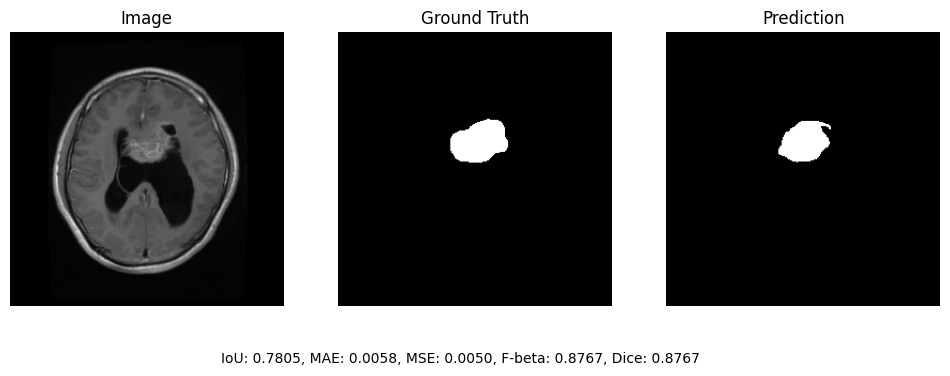

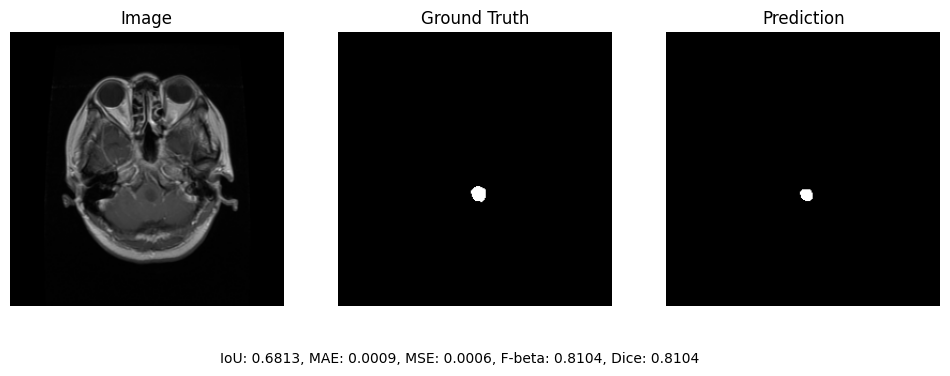

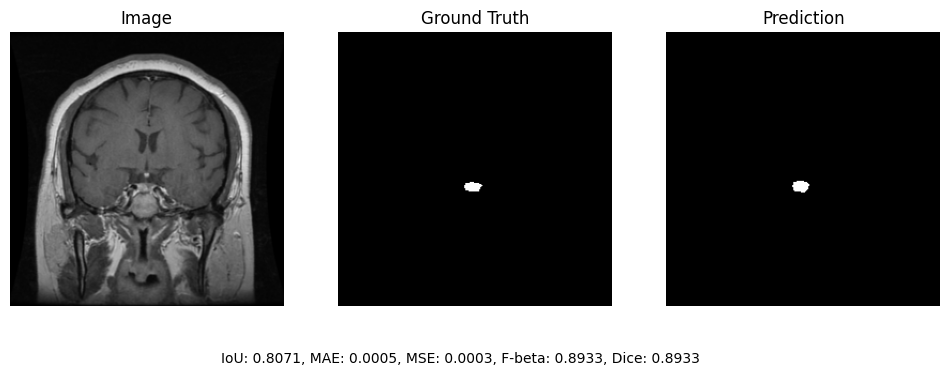

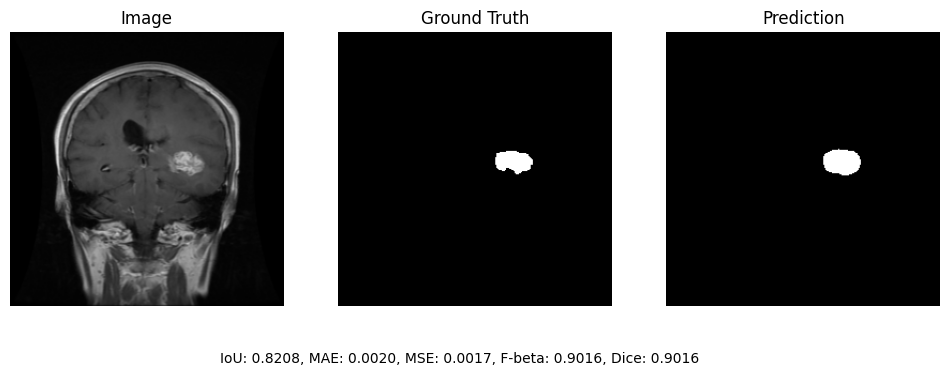

In [ ]:
# --------------------------
# Visualization
# --------------------------
def visualize_predictions(model,dataloader,num_samples=3):
    model.eval()
    # Get a random batch from the dataloader
    random_indices = torch.randperm(len(dataloader.dataset))[:dataloader.batch_size]
    imgs = torch.stack([dataloader.dataset[i][0] for i in random_indices]).to(device)
    masks = torch.stack([dataloader.dataset[i][1] for i in random_indices]).to(device)

    masks = masks.float()
    if masks.ndim == 3:
        masks = masks.unsqueeze(1)
    preds = model(imgs)
    preds_bin = (preds>0.5).float()
    for i in range(min(num_samples,imgs.size(0))):
        img = imgs[i].permute(1,2,0).cpu().numpy()
        mask = masks[i].squeeze().cpu().numpy()
        pred = preds_bin[i].squeeze().cpu().numpy()
        pred_raw = preds[i].squeeze().detach().cpu().numpy() # Use raw predictions for MAE/MSE

        # Calculate metrics for each image
        iou = jaccard_score(mask.flatten(), pred.flatten())
        mae = mean_absolute_error(mask.flatten(), pred_raw.flatten())
        mse = mean_squared_error(mask.flatten(), pred_raw.flatten())
        fbeta = fbeta_score(mask.flatten(), pred.flatten(), beta=1.0)
        dice = (2. * (pred * mask).sum() + 1e-6) / (pred.sum() + mask.sum() + 1e-6) # Calculate Dice


        plt.figure(figsize=(12,4)) # Increased figure size
        plt.subplot(1,3,1);plt.imshow(img);plt.title("Image");plt.axis("off")
        plt.subplot(1,3,2);plt.imshow(mask,cmap="gray");plt.title("Ground Truth");plt.axis("off")
        plt.subplot(1,3,3);plt.imshow(pred,cmap="gray");plt.title("Prediction");plt.axis("off")

        # Add text for metrics
        plt.figtext(0.5, 0.01, f"IoU: {iou:.4f}, MAE: {mae:.4f}, MSE: {mse:.4f}, F-beta: {fbeta:.4f}, Dice: {dice:.4f}", ha="center", fontsize=10) # Added Dice to text


        plt.show()

visualize_predictions(model,val_loader,num_samples=5)
torch.save(model.state_dict(),"fusionnetx.pth")